In [15]:
#Monte Carlo simulation for Argon atoms under the Lenard-Jones potential.
#Lennard-Jones: V(r) = 4E(sigma/r**12 - sigma/r**6)
#reduced distance unit is sigma = 1 where for argon sigma = 2.4 angstrom
#reduced energy unit is E=1 where for argon e=eV
#Resulting potential is V(r) = 4(1/r**12-1/r**6)
#and force magnitude is F(r) = 24(2/r**13-1/r**7)

import numpy as np

def sign(a, b):    #utility function to select proper sign for flipping distance
    if (b >=  0.0):
        return abs(a)
    else:
        return  - abs(a)

##########Define the number of atoms so it is a perfect square, simplifies setup
Natoms=256
sqrtNatoms=int(np.sqrt(Natoms))
Nsteps =  10000
Kinit = 2.0    #initial average kinetic energy of each particle
v0=np.sqrt(2.*Kinit)    #initial average speed of each particle, m=1
dt = 0.02

##########Now define all the variable arrays.  For now, do not keep track of forces.
x  = np.zeros( (Natoms,Nsteps),    float)                       # x position of atoms
y  = np.zeros( (Natoms,Nsteps),    float)                       # y position
vx = np.zeros( (Natoms,Nsteps),    float)               # x vel. x of atoms
vy = np.zeros( (Natoms,Nsteps),    float)                # y component velocity atoms
#fx = np.zeros( (Natoms,Nsteps, 2), float)                      # x component of force
#fy = np.zeros( (Natoms,Nsteps, 2), float)                      # y component of force

##########setup the initial grid of particles, placing them in a squarish configuration
sigspace = 5.0 #average spacing between particles in sigma units
L = sigspace*sqrtNatoms                    # side of square  
halfsig=sigspace/2.    #used for offset from x/y=0 and x/y=L

#for now put each particle equally spaced in the region modified by a small amount
xvals=np.linspace(halfsig,L-halfsig,sqrtNatoms)
yvals=np.linspace(halfsig,L-halfsig,sqrtNatoms)
#startpos=[[xs,ys] for xs in xvals for ys in yvals] alternative position set

for ix in range(0, sqrtNatoms):                   # x->   0  1  2  3  4
    for iy in range(0, sqrtNatoms):               # y=0   0  5  10 15 20 
         x[sqrtNatoms*ix+iy,0]=xvals[ix] + np.random.rand()-0.5
         y[sqrtNatoms*ix+iy,0]=yvals[iy] + np.random.rand()-0.5
         #vx[sqrtNatoms*ix+iy,0]=twelveran()*sqrtKinit
         #vy[iy+sqrtNatoms*ix,0]=twelveran()*sqrtKinit
         angle=np.random.rand()*2.*np.pi               #to randomize v direction
         vx[sqrtNatoms*ix+iy,0]=v0*np.cos(angle)
         vy[sqrtNatoms*ix+iy,0]=v0*np.sin(angle)

##########do the first step with Euler  new pos = old pos + old vel*time step
#for now, this is the only use of the speed array which is not now updated
for n1 in range(0, Natoms):
    x[n1,1]= x[n1,0] + vx[n1,0]*dt
    y[n1,1]= y[n1,0] + vy[n1,0]*dt
    vx[n1,1]= vx[n1,0]
    vy[n1,1]= vy[n1,0]

##########now do all other steps with Verlet starting with third position
for ns in range(2, Nsteps):

    #this for loop checks for particles that have left the box, and re-introduces them 
    #on the other side.  It also adjust the previous position to make Verlet
    #calculation consistent.  As a result, some particle positions will be
    #slightly outside the box, but they will be traveling back into it
    for k in range(0,Natoms):
        if x[k,ns-1] > L:
            x[k,ns-1] = x[k,ns-1] - L
            x[k,ns-2] = x[k,ns-2] - L
        elif x[k,ns-1] < 0:
            x[k,ns-1] = x[k,ns-1] + L
            x[k,ns-2] = x[k,ns-2] + L
        if y[k,ns-1] > L:
            y[k,ns-1] = y[k,ns-1] - L
            y[k,ns-2] = y[k,ns-2] - L
        elif y[k,ns-1] < 0:
            y[k,ns-1] = y[k,ns-1] + L
            y[k,ns-2] = y[k,ns-2] + L
    
    #Now loop over all atoms . . . . 
    for n in range(0, Natoms):
        accx=0
        accy=0
        #. . . . and for each atom, find the current force/acceleration from all other atoms
        for m in range(0, Natoms): 
            if m == n:
               continue
#calculate the minimum x distance
            dx=x[n,ns-1]-x[m,ns-1]
            dy=y[n,ns-1]-y[m,ns-1]
            if np.abs(dx) > L/2.:
                #dx=dx-L/2.
                dx = dx  -  sign(L, dx)    # interact with closer image
#now get the minimum y distance
            if np.abs(dy) > L/2.:
                dy = dy  -  sign(L, dy)
          
            rmn=np.sqrt(dx*dx+dy*dy)
            if rmn > 6.0:
                continue      #if the particle is beyond some max dist, ignore
            elif rmn < 0.0001:
                rmn=0.0001  #limit the approach of particles, including the rmn=0 case
            fmn = 24.*(2./rmn**13 - 1./rmn**7)  #force on n from m
            thetamn=np.arctan2(dy,dx)
            accx+=fmn*np.cos(thetamn)   #accelerations, remember m = 1 otherwise divide f by m
            accy+=fmn*np.sin(thetamn)
        #Verlet formula, new position depends on previous two and acceleration term
        x[n,ns]= 2.*x[n,ns-1] - x[n,ns-2] + accx*dt**2
        y[n,ns]= 2.*y[n,ns-1] - y[n,ns-2] + accy*dt**2
        #could calculate speed later, but go ahead and use central difference formula
        vx[n,ns-1]= (x[n,ns] - x[n,ns-2])/(2.*dt)
        vy[n,ns-1]= (y[n,ns] - y[n,ns-2])/(2.*dt)


In [16]:
2.5*2.5*2

12.5

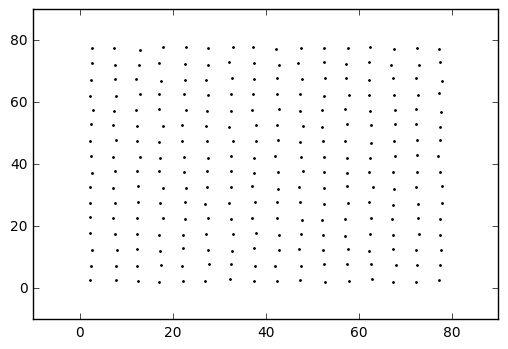

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(x[:,0],y[:,0],s=1)

In [ ]:
y[0:31,1]

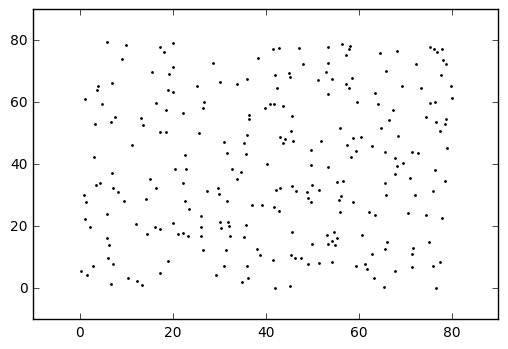

In [18]:
plt.scatter(x[:,900],y[:,900],s=1)

(array([   0.,   48.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  208.]),
 array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.]),
 <a list of 10 Patch objects>)

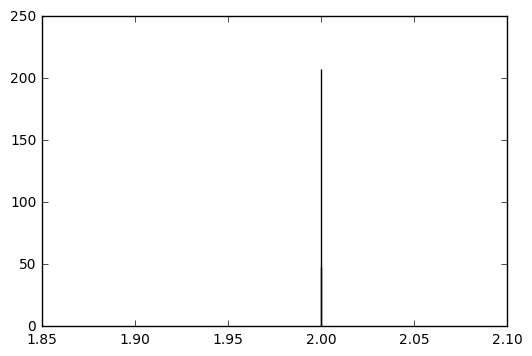

In [20]:
plt.hist(np.sqrt(vx[:,0]**2+vy[:,0]**2))

(array([  4.,   2.,   5.,   3.,   7.,  11.,  11.,  19.,   8.,  22.,  12.,
         18.,  15.,  12.,  21.,  14.,   7.,  10.,   7.,   9.,   7.,  10.,
          2.,   8.,   4.,   2.,   0.,   1.,   0.,   1.,   3.,   1.]),
 array([ 0.07185096,  0.20881519,  0.34577942,  0.48274365,  0.61970788,
         0.75667211,  0.89363634,  1.03060057,  1.16756481,  1.30452904,
         1.44149327,  1.5784575 ,  1.71542173,  1.85238596,  1.98935019,
         2.12631442,  2.26327865,  2.40024289,  2.53720712,  2.67417135,
         2.81113558,  2.94809981,  3.08506404,  3.22202827,  3.3589925 ,
         3.49595673,  3.63292097,  3.7698852 ,  3.90684943,  4.04381366,
         4.18077789,  4.31774212,  4.45470635]),
 <a list of 32 Patch objects>)

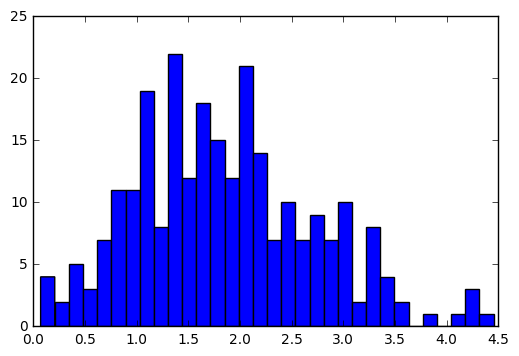

In [19]:
plt.hist(np.sqrt(vx[:,900]**2+vy[:,900]**2),32)